In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore') # filter some warning messages
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import seaborn as sns
import glob
import os
import fnmatch

In [2]:
# Generals
ldp = '/Users/sol/Documents/LargeData/' # data folder
months=['January','February','March','April','May','June','July','August','September','October','November','December']

# reginoal domain
#ldom = np.array([[42.9, 48.4],[-126, -123]]) 
ldom = np.array([[43, 48.5],[-129, -123]]) 
ldom = np.array([[46.5,47.5],[-125.1,-124]])
# QIN domain
qbox = np.array([[-124.05,-124.33,-125.07,-124.774,-124.05],[46.53,47.4,47.4,46.53,46.53]]) 

In [3]:
#get bathymetry from ETOPO1
fn = ldp+'/Etopo/ETOPO1_Ice_g_gmt4.grd'
ds_topo = xr.open_dataset(fn)
ds_topo.close()
topo = ds_topo.z  #(10801, 21601)
topo2=topo.sel(y=slice(ldom[0,0],ldom[0,1]),x=slice(ldom[1,0],ldom[1,1]))
x = topo2.x  #21601
y = topo2.y   #10801
X,Y=np.meshgrid(x,y)

In [4]:
qin = xr.open_dataset(ldp+'/QIN/qin_mask.nc')
qin.close()
qin.coords['lon'] = np.mod(qin.coords['lon'] + 180,360) - 180
qin = qin.polygon_mask.sel(lat=slice(ldom[0,0],ldom[0,1]),lon=slice(ldom[1,0],ldom[1,1]))
qin = qin.where(qin!=0,np.nan)

eez = xr.open_dataset(ldp+'/QIN/eez_mask.nc')
eez.close()
eez.coords['lon'] = np.mod(eez.coords['lon'] + 180,360) - 180
eez = eez.region_mask.sel(lat=slice(ldom[0,0],ldom[0,1]),lon=slice(ldom[1,0],ldom[1,1]))
eez = eez.where(eez!=0,np.nan)

Xm, Ym = np.meshgrid(eez.lon,eez.lat)

# number of pixels in the mask
npx = qin.count(dim=['lat','lon']).values

In [5]:
fishes = ['Sablefish','Dungeness Crab','Hake','Lingcod','P. Halibut','Chinook','Coho','Steelhead']
var = ['thetao','o2']   
depth = ['surface','bottom']
ssps = ['ssp485','ssp585']
Trange = np.array([[4.72, 12.85],[5.36,11.72],[1.18,23.29],[6.56,13],[2.92,9.28],[3.49,11.65],[4.43,12.35],[6.38,16]])
O2range = np.array([[35.13, 400],[107.91,400],[111,169],[33.55,400],[55.67,400],[54.42,400],[58.94,400],[94.27,400]])
O2range = O2range/44.661  # conversion to ml/l
Deprange = np.array([[175, 1450],[41,90],[126,229],[18,60],[155,515],[43,172],[28,118],[22,95]])

In [6]:
def suitable_habitat_monthly_allmod_comb(fish):
    for i,ina in enumerate(fishes):
        if fish in ina:
            fishnum=i
            
    # decades to average
    yrsav = [*range(1990,2100,10)]
    
    for clim in ssps:
        for i2 in depth:
            # for each variable at given depth
            for i in var:
                tmp1 = np.full((len(qin.lat.values),len(qin.lon.values),len(yrsav),9),np.nan)
                # optimal range thresholds
                if i=='thetao':
                    th1 = Trange[fishnum,0]
                    th2 = Trange[fishnum,1]
                else:
                    th1 = O2range[fishnum,0]
                    th2 = O2range[fishnum,1]
                # for each model
                fns = glob.glob(ldp+'/QIN/downscaled_data/'+clim+'/'+i+'/'+i2+'/*.nc')
                # build datasets from all models
                for modn,fn in enumerate(fns):
                    # model name
                    tmps = fn.split('/')
                    tmps2 = tmps[-1].split('_')
                    modname = tmps2[0]+'_'+tmps2[1]
                    #print(modn,models[nummod])
                    ds_Ts = xr.open_dataset(fn)
                    ds_Ts.close()
                    ds_Ts.coords['lon'] = np.mod(ds_Ts.coords['lon'] + 180,360) - 180
                    # select only region of interest (large)
                    ds_Ts = ds_Ts[i].sel(lat=slice(ldom[0,0],ldom[0,1]),lon=slice(ldom[1,0],ldom[1,1]),time=slice('1994-01-01','2099-12-31'))
                    # select optimal range
                    tmp = ds_Ts.where((ds_Ts>=th1)&(ds_Ts<=th2), np.nan)
                    # mask qin region
                    tmp = tmp*qin
                    # make mask
                    tmp = tmp*0+1
                    
                    # data array
                    if modn==0:
                        fechas = ds_Ts.time
                    tmp_ds = xr.DataArray(data=tmp,dims=['time','lat','lon'],
                                        coords=dict(time=fechas,lat=ds_Ts.lat,lon=ds_Ts.lon))
                    
                    if i=='thetao':
                        if modn==0: 
                            allmodT = xr.Dataset({modname:tmp_ds})
                        else:
                            allmodT[modname] = tmp_ds
                    else:
                        if modn==0: 
                            allmodO = xr.Dataset({modname:tmp_ds})
                        else:
                            allmodO[modname] = tmp_ds
                    
            # compare that both vars in each models
            # for each model that has Oxygen
            di = 0
            for i in list(allmodO):
                tmpO = allmodO[i].values
                try:
                    tmpT = allmodT[i].values
                    OTcomb = tmpO + tmpT
                    tmp_OT = xr.DataArray(data=OTcomb, dims=['time','lat','lon'],
                                        coords=dict(time=fechas,lat=ds_Ts.lat,lon=ds_Ts.lon))
                    # suitable habitat
                    Sh_tmp = np.round(tmp_OT.count(dim=['lat','lon']).values*100/npx,1)
                    tmp = xr.DataArray(data=Sh_tmp, dims=['time'], coords=dict(time=fechas))
                    if di==0:
                        allmod_otcomb = xr.Dataset({i:tmp})
                        di += 1
                    else:
                        allmod_otcomb[i] = tmp
                except:
                    x=1
            
            varns = clim+'_'+i2
            allmod_otcomb.to_netcdf(ldp+'QIN/downscaled_data/OT_'+fish+'_'+varns+'_allmods.nc')
                

In [7]:
def plot_decadal_timseries_ensemble(fish, dp, ssp):
    ds = xr.open_dataset(ldp+'QIN/downscaled_data/OT_'+fish+'_'+ssp+'_'+dp+'_allmods.nc')
    ds.close()

    yrsav = [*range(1990,2101,10)]
    yrs = ds.time.dt.year.values
    Sh_Ts_dec = np.full((len(yrsav)-1,len(list(ds))),np.nan)
    for idx,i in enumerate(list(ds)):
        for j in range(len(yrsav)-1):
            a=(yrs>=yrsav[j])&(yrs<=yrsav[j+1])
            tmp = ds[i].values
            Sh_Ts_dec[j,idx] = np.nanmean(tmp[a])

    plt.figure(figsize=(8,4))
    plt.plot(yrsav[:-1], Sh_Ts_dec,'.-',c='grey', alpha=0.6,zorder=1)
    plt.errorbar(yrsav[:-1], np.nanmean(Sh_Ts_dec, axis=1), yerr=np.nanstd(Sh_Ts_dec, axis=1),c='tab:red', lw=3, zorder=2)
    plt.grid(True, alpha=0.3, zorder=0)
    plt.title(fish+', '+dp+', '+ssp)
    plt.ylabel('Suitable Habitat (%)')
    plt.ylim([0,100])
    plt.show()

In [8]:
def plot_decadal_hovmuller_ensemble(fish, dp, ssp):
    # plot hovmuller
    ds = xr.open_dataset(ldp+'QIN/downscaled_data/OT_'+fish+'_'+ssp+'_'+dp+'_allmods.nc')
    ds.close()

    yrsav = [*range(1990,2101,10)]
    yrs = np.unique(ds.time.dt.year.values)
    Sh_Ts_dec_hv = np.full((len(yrsav)-1,12,len(list(ds))),np.nan)

    for idx,i in enumerate(list(ds)): # for each model
        tmp = ds[i].values
        tmp = tmp.reshape((int(len(tmp)/12)), 12)
        for j in range(len(yrsav)-1): # for each decade
            a=(yrs>=yrsav[j])&(yrs<=yrsav[j+1])
            for k in range(12):
                Sh_Ts_dec_hv[j,k,idx] = np.nanmean(tmp[a,k])

    Sh_Ts_dec_hvm = np.full((12,len(yrsav)-1),np.nan)
    Sh_Ts_dec_hvs = np.full((12,len(yrsav)-1,),np.nan)
    for j in range(len(yrsav)-1):
        for i in range(12):
            Sh_Ts_dec_hvm[i,j] = np.nanmedian(Sh_Ts_dec_hv[j,i,:])
            Sh_Ts_dec_hvs[i,j] = np.nanstd(Sh_Ts_dec_hv[j,i,:])

    plt.figure(figsize=(10,4))
    ax=sns.heatmap(Sh_Ts_dec_hvm, yticklabels=months, xticklabels=yrsav[:-1], linewidths=0, alpha=0.85, vmin=0, vmax=100)
    X2, Y2 = np.meshgrid(np.arange(0.5,len(yrsav[:-1])),np.arange(0.5,12))
    plt.scatter(X2, Y2, s=Sh_Ts_dec_hvs,c='w',marker='o', edgecolor='grey', alpha=0.6)
    plt.title(fish+', '+dp+', '+ssp)
    plt.show()
    

In [9]:
for fish in fishes:
    suitable_habitat_monthly_allmod_comb(fish)


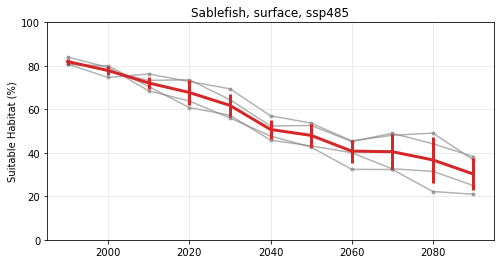

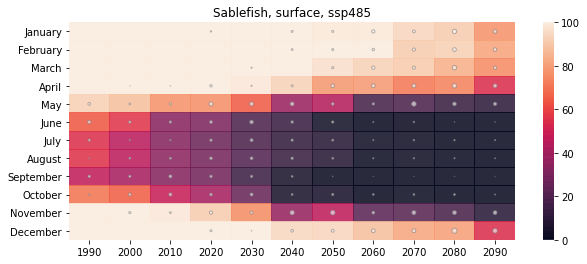

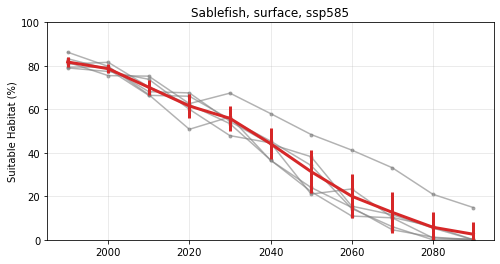

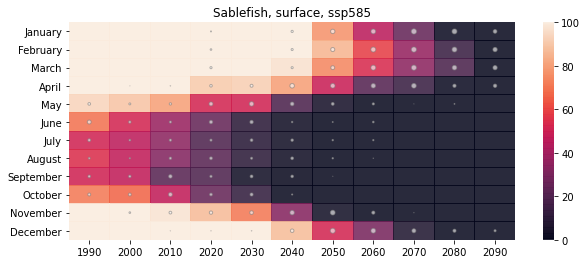

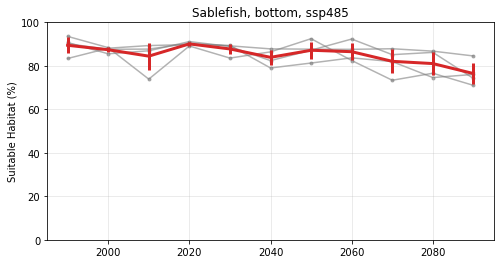

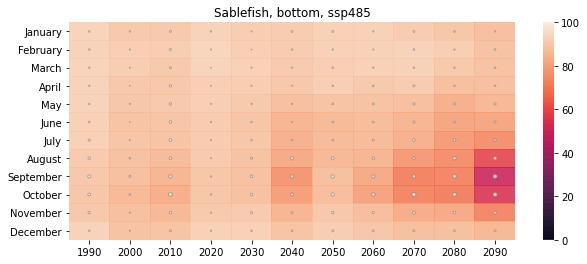

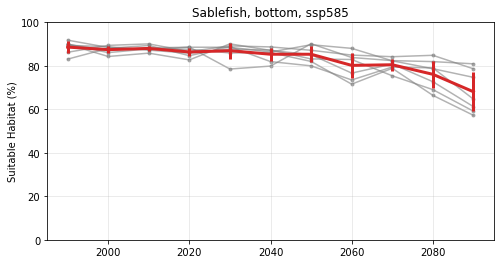

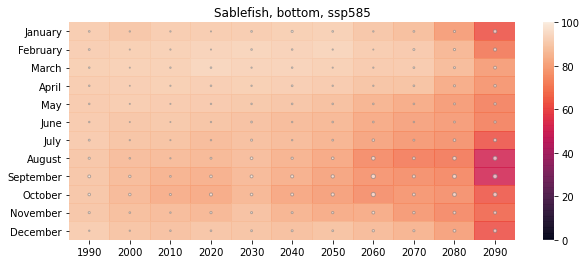

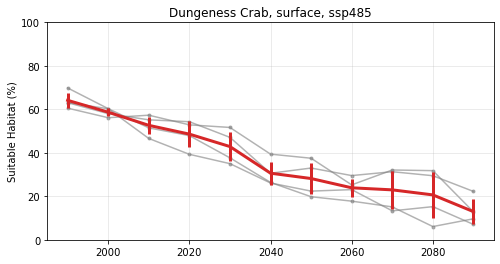

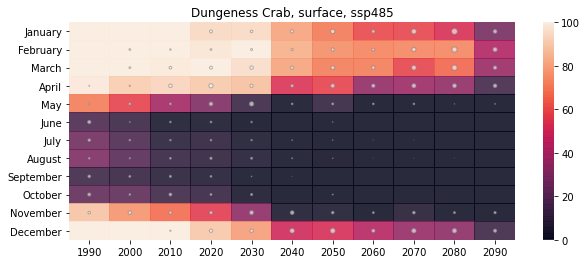

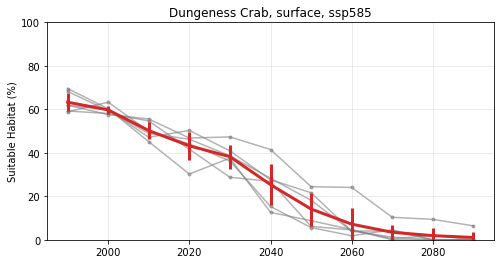

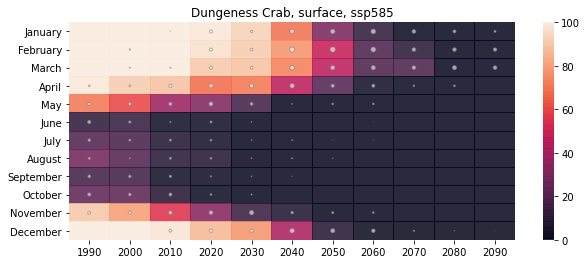

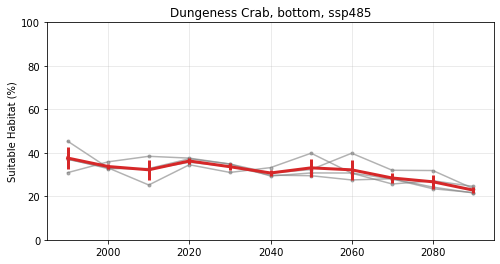

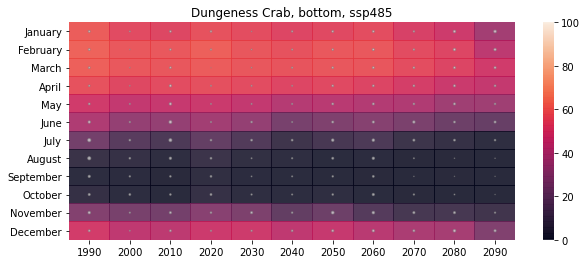

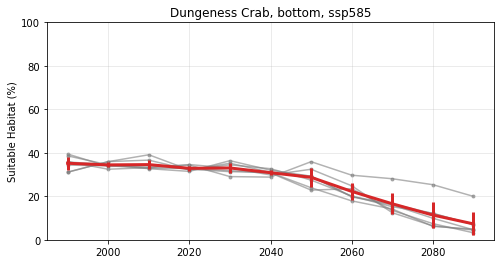

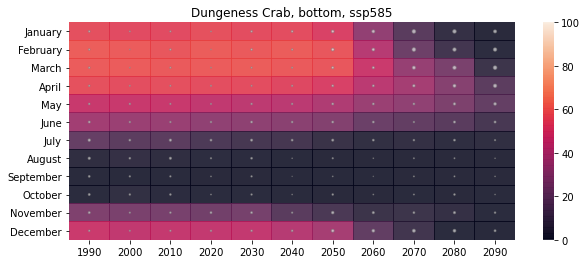

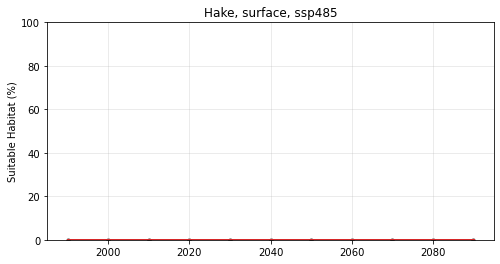

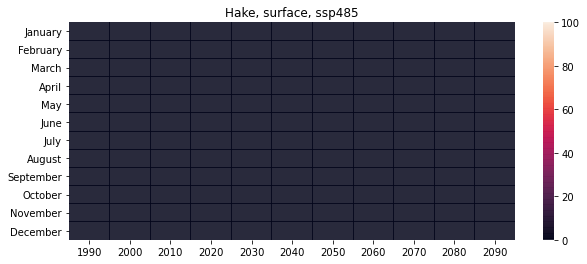

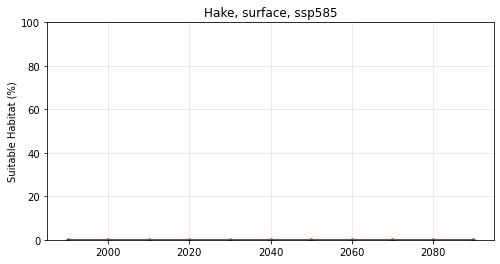

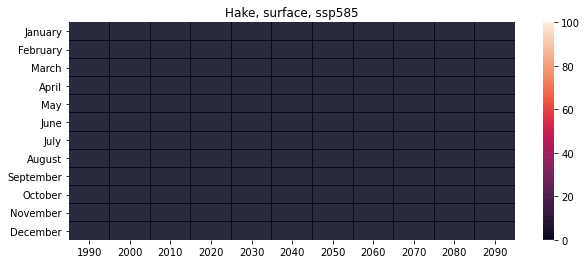

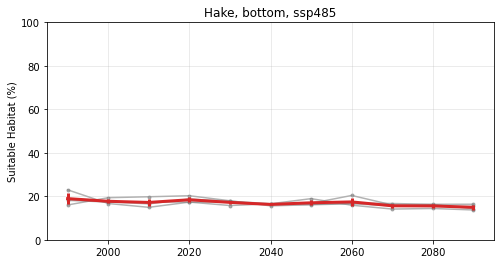

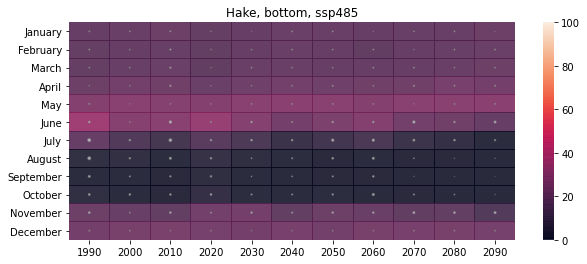

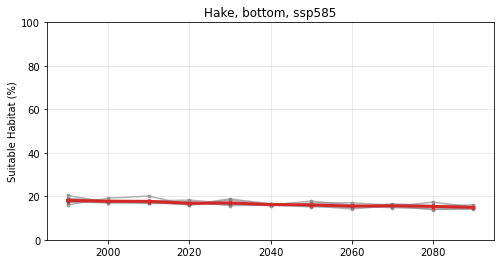

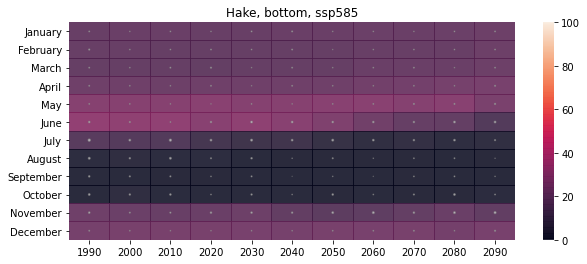

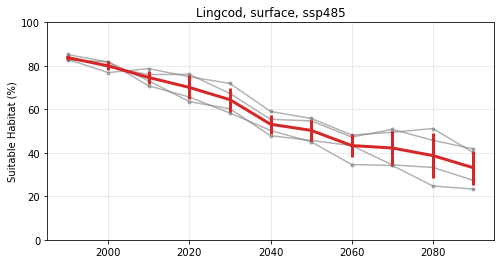

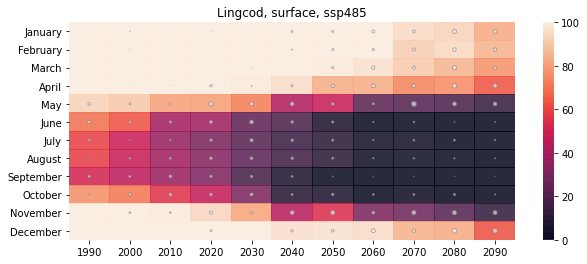

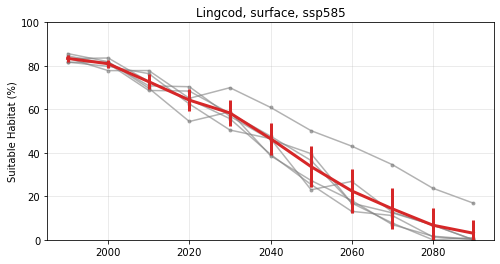

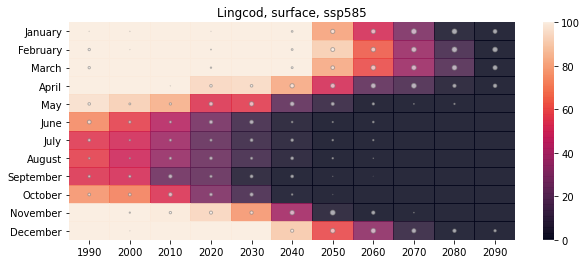

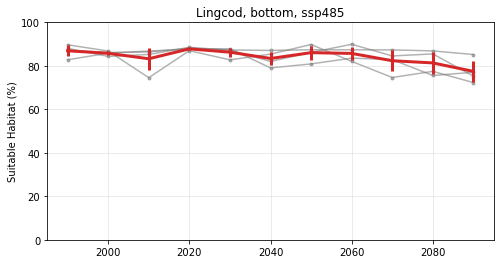

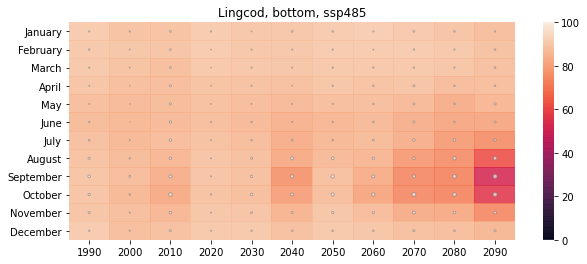

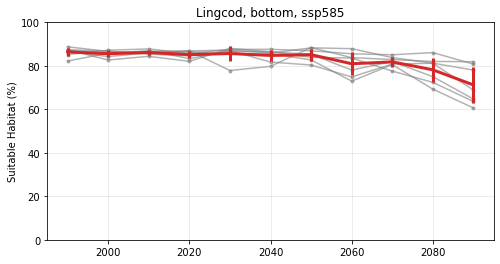

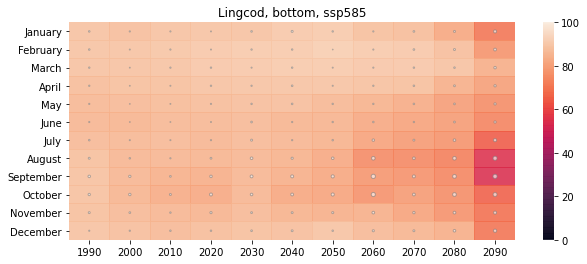

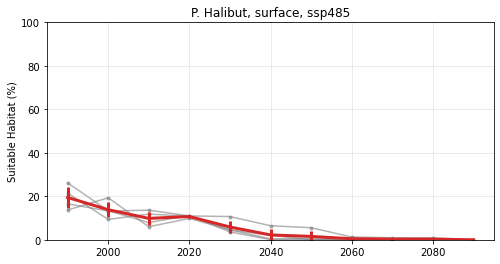

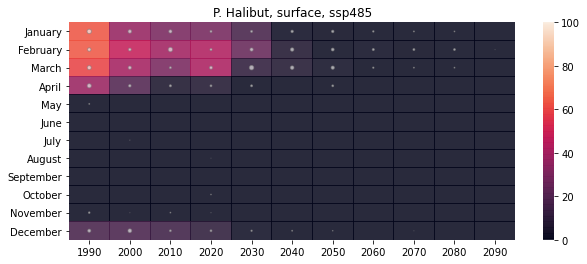

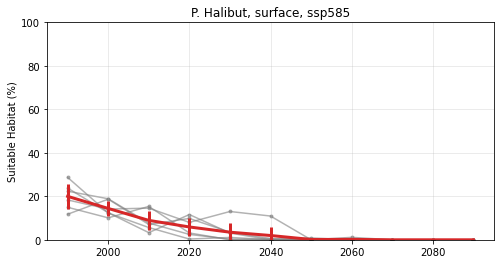

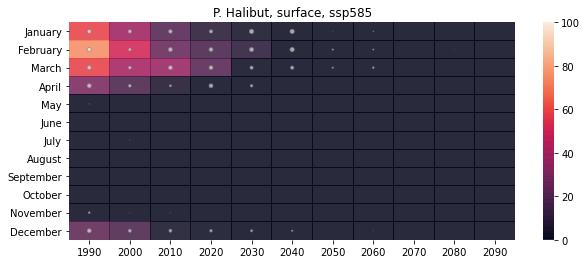

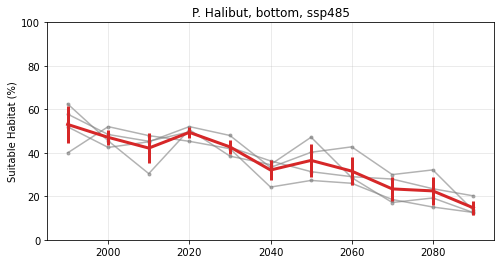

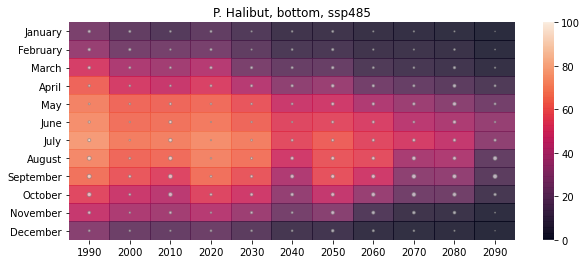

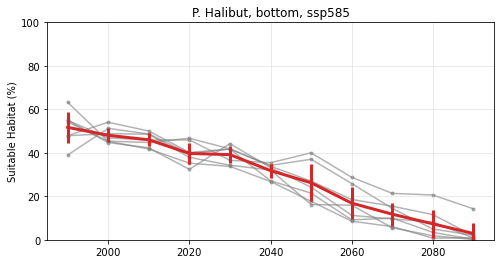

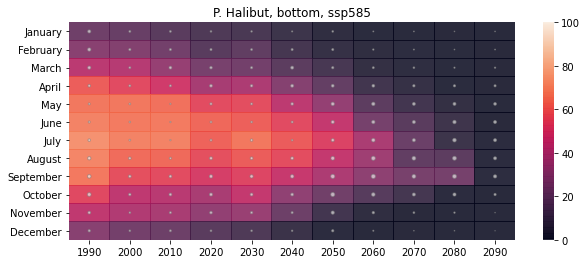

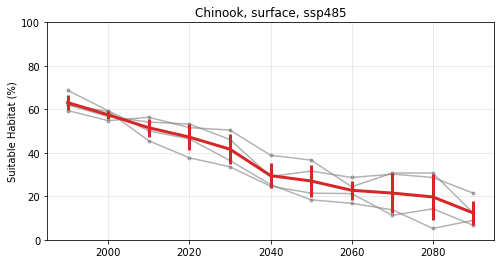

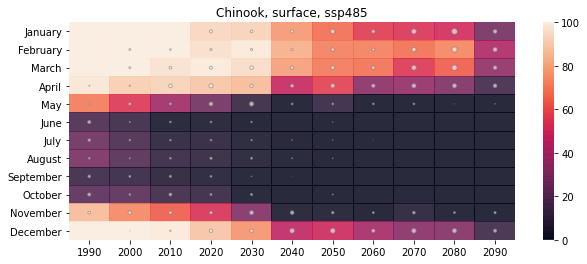

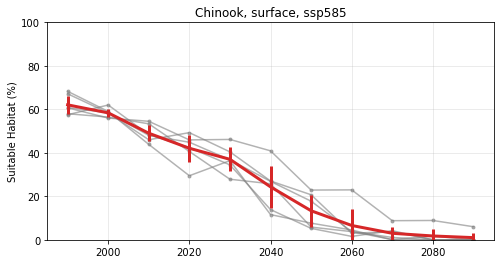

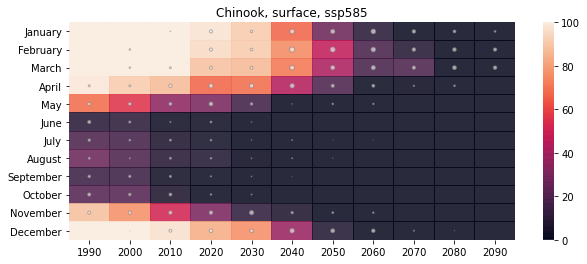

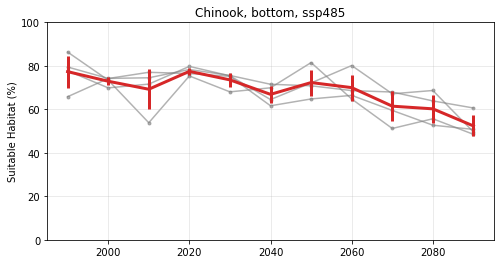

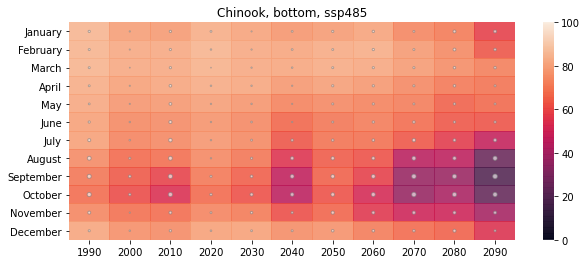

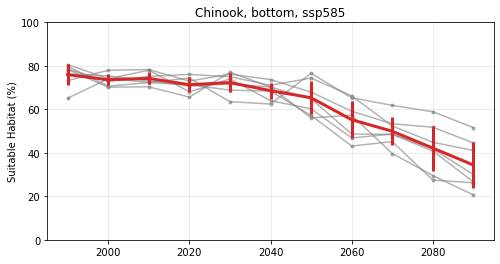

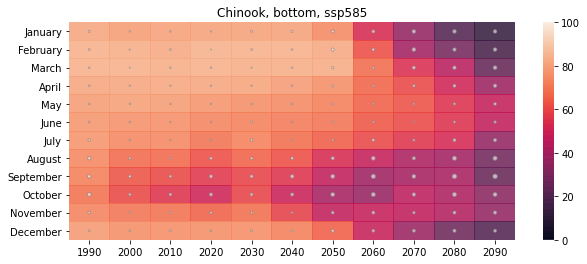

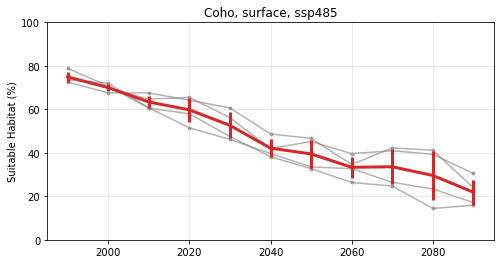

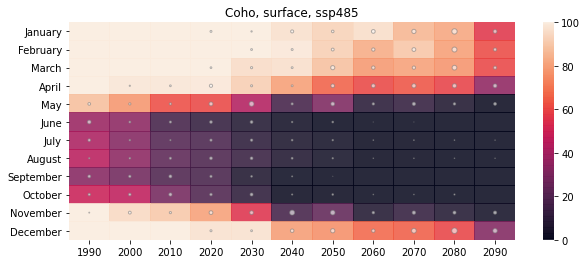

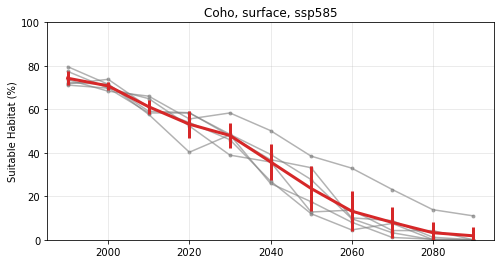

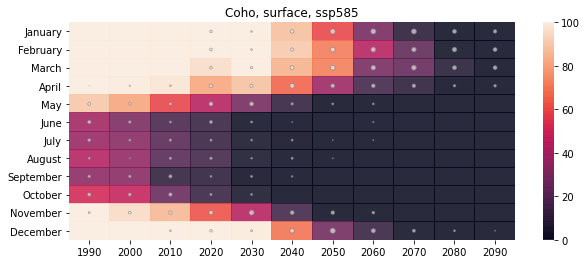

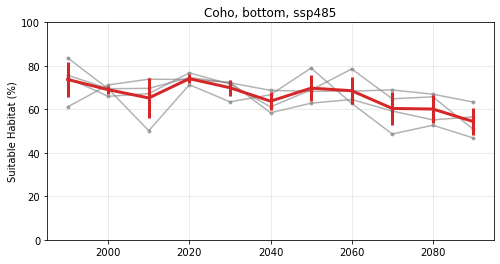

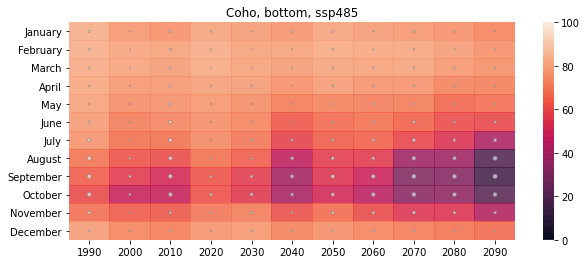

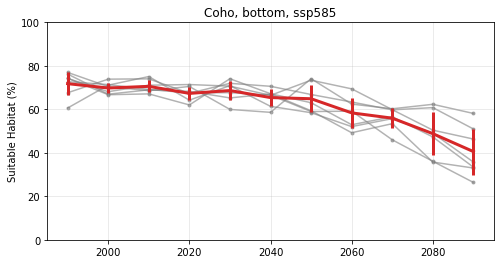

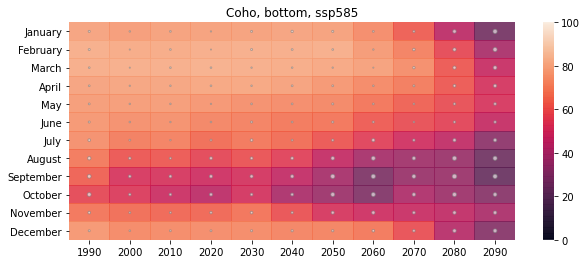

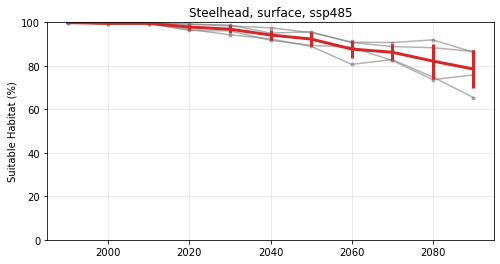

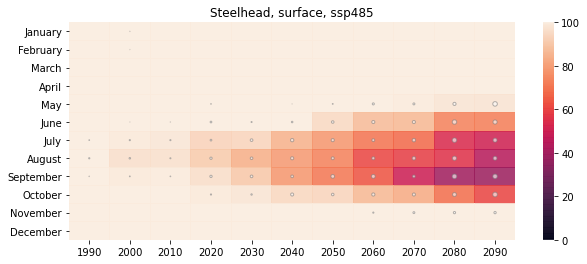

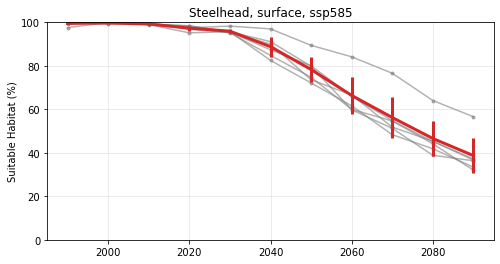

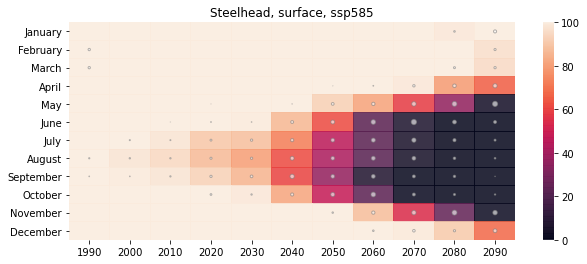

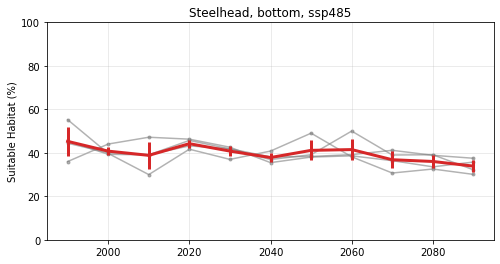

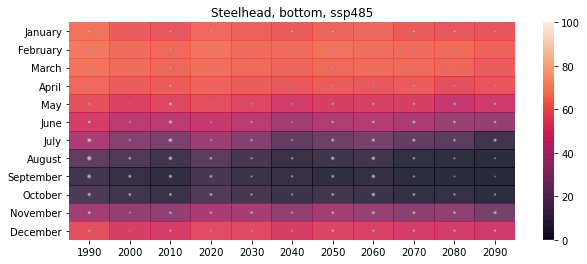

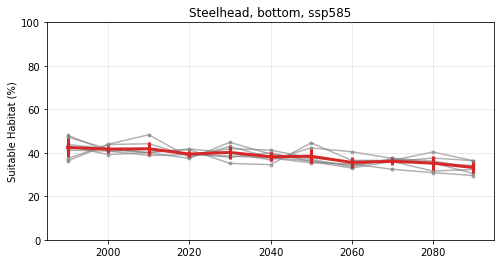

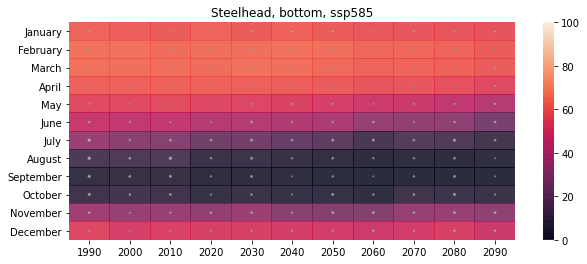

In [10]:
for fish in fishes:
    for dp in depth:
        for scenario in ssps:
            plot_decadal_timseries_ensemble(fish, dp, scenario)
            plot_decadal_hovmuller_ensemble(fish, dp, scenario)
